Most important features (see feature importance and tree plot below):
1. clicks until now 
2. impressions until now

__________________________________

code:
  1. add clicks so far

  df = df.sort_values(by=['user_id', 'DateTime'])
  df['clicks_so_far'] = df.groupby('user_id')['is_click'].cumsum()

  2. add exposure so far
  
  df = df.sort_values(by=['user_id', 'DateTime'])
  df['exposures_so_far'] = df.groupby('user_id').cumcount()

##imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score

## load data and preprocess

In [2]:
# load data
def load_data():
   df = pd.read_csv('train_CTR.csv',parse_dates=['DateTime'])
   return df

In [3]:
def first_impute(df):
  df.dropna(how='all',inplace=True)
  df.dropna(subset=['is_click'], inplace=True)
  df.webpage_id[(df['campaign_id'].notna()) & (df['webpage_id'] != 13787)] = df.groupby('campaign_id')['webpage_id'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
  df.campaign_id[df['webpage_id'].notna()] = df.groupby('webpage_id')['campaign_id'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

  return df

In [4]:
def second_impute(df):
    col_lists = ['gender', 'age_level', 'user_depth', 'user_group_id', 'city_development_index']

    for col in col_lists:
        # Get most common value per user
        user_value = df.groupby('user_id')[col].value_counts().groupby(level=0).idxmax()
        most_common = user_value.apply(lambda x: x[1] if isinstance(x, tuple) else x).rename(f"{col}_imputed")

        # Merge with df
        df = df.merge(most_common, on='user_id', how='left')

        # Fill missing values in df[col] with the imputed values
        df[col].fillna(df[f"{col}_imputed"], inplace=True)

        # Drop the temporary column
        df.drop(columns=[f"{col}_imputed"], inplace=True)

    return df



In [5]:
def third_impute(df):
  # add clicks so far
  df = df.sort_values(by=['user_id', 'DateTime'])
  df['clicks_so_far'] = df.groupby('user_id')['is_click'].cumsum()

  # add exposure so far
  df = df.sort_values(by=['user_id', 'DateTime'])
  df['exposures_so_far'] = df.groupby('user_id').cumcount()

  # handle DateTime
  df['date'] = df['DateTime'].dt.day
  df['hour'] = df['DateTime'].dt.hour
  df.drop(columns='DateTime',inplace=True)

  return df


In [6]:
mapping = {
    (1, 'Male'): 1,
    (2, 'Male'): 2,
    (3, 'Male'): 3,
    (4, 'Male'): 4,
    (5, 'Male'): 5,
    (6, 'Male'): 6,
    (1, 'Female'): 7,
    (2, 'Female'): 8,
    (3, 'Female'): 9,
    (4, 'Female'): 10,
    (5, 'Female'): 11,
    (6, 'Female'): 12
    }

def replace_with_dummies(col_names, df):
    df = df.copy()  # Avoid modifying the original DataFrame
    dummies_list = [pd.get_dummies(df[col], prefix=col, dtype=int) for col in col_names]
    df = df.drop(columns=col_names)  # Fixed inplace issue
    df = pd.concat([df] + dummies_list, axis=1)  # Efficiently add new dummies
    return df  # Return the modified DataFrame

def fill_gender_age_based_on_user_group(row):
    if pd.isna(row['gender']) and pd.notna(row['user_group_id']):
        row['gender'] = 'Male' if row['user_group_id'] <= 6 else 'Female'
    if pd.isna(row['age_level']) and pd.notna(row['user_group_id']):
        row['age_level'] = row['user_group_id'] if row['user_group_id'] <= 6 else row['user_group_id'] - 6
    if pd.isna(row['user_group_id']):
        age_gender_key = (row['age_level'], row['gender'])
        row['user_group_id'] = mapping.get(age_gender_key, np.nan)
    return row

def fourth_impute(df):
    # Add campaign_imp_per_hour
    campaign_imp_per_hour = df.groupby(['date', 'hour', 'campaign_id']).size().groupby(['hour', 'campaign_id']).mean().unstack()
    campaign_imp_per_hour /= campaign_imp_per_hour.sum(axis=0)

    df = df.merge(
        campaign_imp_per_hour.stack().rename('campaign_imp_per_hour').reset_index(),
        how='left',
        on=['campaign_id', 'hour']
    )

    # Replace categorical variables with dummies
    cols = ['gender', 'product', 'campaign_id', 'webpage_id', 'product_category_1']
    df = replace_with_dummies(cols, df)

    # Add time_in_day
    arr = np.zeros((2, 24))
    arr[0, :] = df.groupby('hour').size().sort_values().index
    arr[1, :] = [1,1,1,1,1,2,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5]
    time_in_day = pd.DataFrame(arr.T, columns=['hour', 'time_id_day'])

    df = df.merge(time_in_day, how='left', on='hour')

    df.drop_duplicates(inplace=True)

    return df

In [7]:
#impute
def impute(df):
  first_impute(df)
  return df

In [ ]:
df = impute(load_data())


In [ ]:
df = second_impute(df)

In [11]:
df = third_impute(df)

In [12]:
df = fourth_impute(df)

In [ ]:
# drop cols with more than 10K nulls
df = df.drop(columns=['product_category_2', 'city_development_index'])

In [28]:
df = df.dropna()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367080 entries, 0 to 383669
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              367080 non-null  float64
 1   user_id                 367080 non-null  float64
 2   user_group_id           367080 non-null  float64
 3   age_level               367080 non-null  float64
 4   user_depth              367080 non-null  float64
 5   var_1                   367080 non-null  float64
 6   is_click                367080 non-null  float64
 7   clicks_so_far           367080 non-null  float64
 8   exposures_so_far        367080 non-null  float64
 9   date                    367080 non-null  float64
 10  hour                    367080 non-null  float64
 11  campaign_imp_per_hour   367080 non-null  float64
 12  gender_Female           367080 non-null  int64  
 13  gender_Male             367080 non-null  int64  
 14  product_A               3

##split data

In [32]:
from sklearn.model_selection import train_test_split
def split(df):
  X = df.copy()
  y = df['is_click']


  X.drop(columns='is_click',inplace=True)

  X_train, X_test, y_train, y_test = train_test_split(X,y)
  return X_train, X_test, y_train, y_test



In [33]:
X_train, X_test, y_train, y_test = split(df)

##models

## XGBOOST

In [35]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    roc_auc_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler



In [37]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    print(f"\n{model_name} Results:")
    print("-" * 50)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model


# logistic regression
lr_model = evaluate_model(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    X_train, X_test, y_train, y_test,
    "Logistic Regression"
)

# random forest
rf_model = evaluate_model(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    X_train, X_test, y_train, y_test,
    "Random Forest"
)

# gradient boosting
gb_model = evaluate_model(
    GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    X_train, X_test, y_train, y_test,
    "Gradient Boosting"
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'seed': 42,
    # Add only minimal adjustments
    'min_child_weight': 3,  # Helps prevent overfitting
    'subsample': 0.9,      # Slight randomness
    'colsample_bytree': 0.9  # Slight feature sampling
}


# xgboost model
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=50
)

# cross-validation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=20,
    metrics=['auc', 'logloss'],
    seed=42
)
y_pred_proba = xgb_model.predict(dtest)  # predict probabilities

# find the optimal threshold for F1 score
thresholds = np.arange(0.2, 0.8, 0.05)
f1_scores = []
for threshold in thresholds:
    y_pred_thresh = (y_pred_proba > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

optimal_threshold = thresholds[np.argmax(f1_scores)]
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

y_pred = (y_pred_proba > optimal_threshold).astype(int)

# feature importance
importance_dict = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    [(k, v) for k, v in importance_dict.items()],
    columns=['feature', 'importance']
).sort_values('importance', ascending=False)

# print evaluation metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score
print("\nXGBoost Results:")
print("-" * 50)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Logistic Regression Results:
--------------------------------------------------
ROC AUC Score: 0.9491
Average Precision Score: 0.4404
Cross-validation ROC AUC: 0.9494 (+/- 0.0024)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     85519
         1.0       0.40      0.96      0.56      6251

    accuracy                           0.90     91770
   macro avg       0.70      0.93      0.75     91770
weighted avg       0.96      0.90      0.92     91770


Random Forest Results:
--------------------------------------------------
ROC AUC Score: 0.9754
Average Precision Score: 0.7375
Cross-validation ROC AUC: 0.9762 (+/- 0.0016)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93     85519
         1.0       0.34      0.99      0.51      6251

    accuracy                           0.87     91770
   macro avg       0.67      0.93      0.72     917

In [ ]:
!pip install -U scikit-learn


In [ ]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Initialize model
XGBoost = HistGradientBoostingClassifier()

# Define parameters (fixing np.arange issue)
params = {
    'learning_rate': list(np.arange(0.01, 0.5, 0.05)),
    'max_iter': list(np.arange(10, 1000, 100)),
    'max_leaf_nodes': [2, 5, 10, 30],
    'min_samples_leaf': [1, 3, 5, 7, 10]
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(XGBoost, params, cv=5, n_jobs=-1)

# Fit model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


In [ ]:
f1_score(XGBoost.predict(X_test),y_test)

0.6941494497007145

In [ ]:
pd.DataFrame(XGBoost.predict(X_test)).value_counts()

,count
0,
0.0,92375
1.0,3849


##Naive

In [ ]:
f1_score(np.ones(y_test.shape[0]),y_test)

0.12588942504293776

##Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [48]:
tree.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
from sklearn.metrics import f1_score

f1_score(tree.predict(X_test),y_test)

0.6775298391281785

In [50]:
pd.DataFrame(tree.predict(X_test)).value_counts()

,count
0,
0.0,88386
1.0,3384


In [ ]:
# !pip install --upgrade hepml

In [45]:
# %matplotlib inline

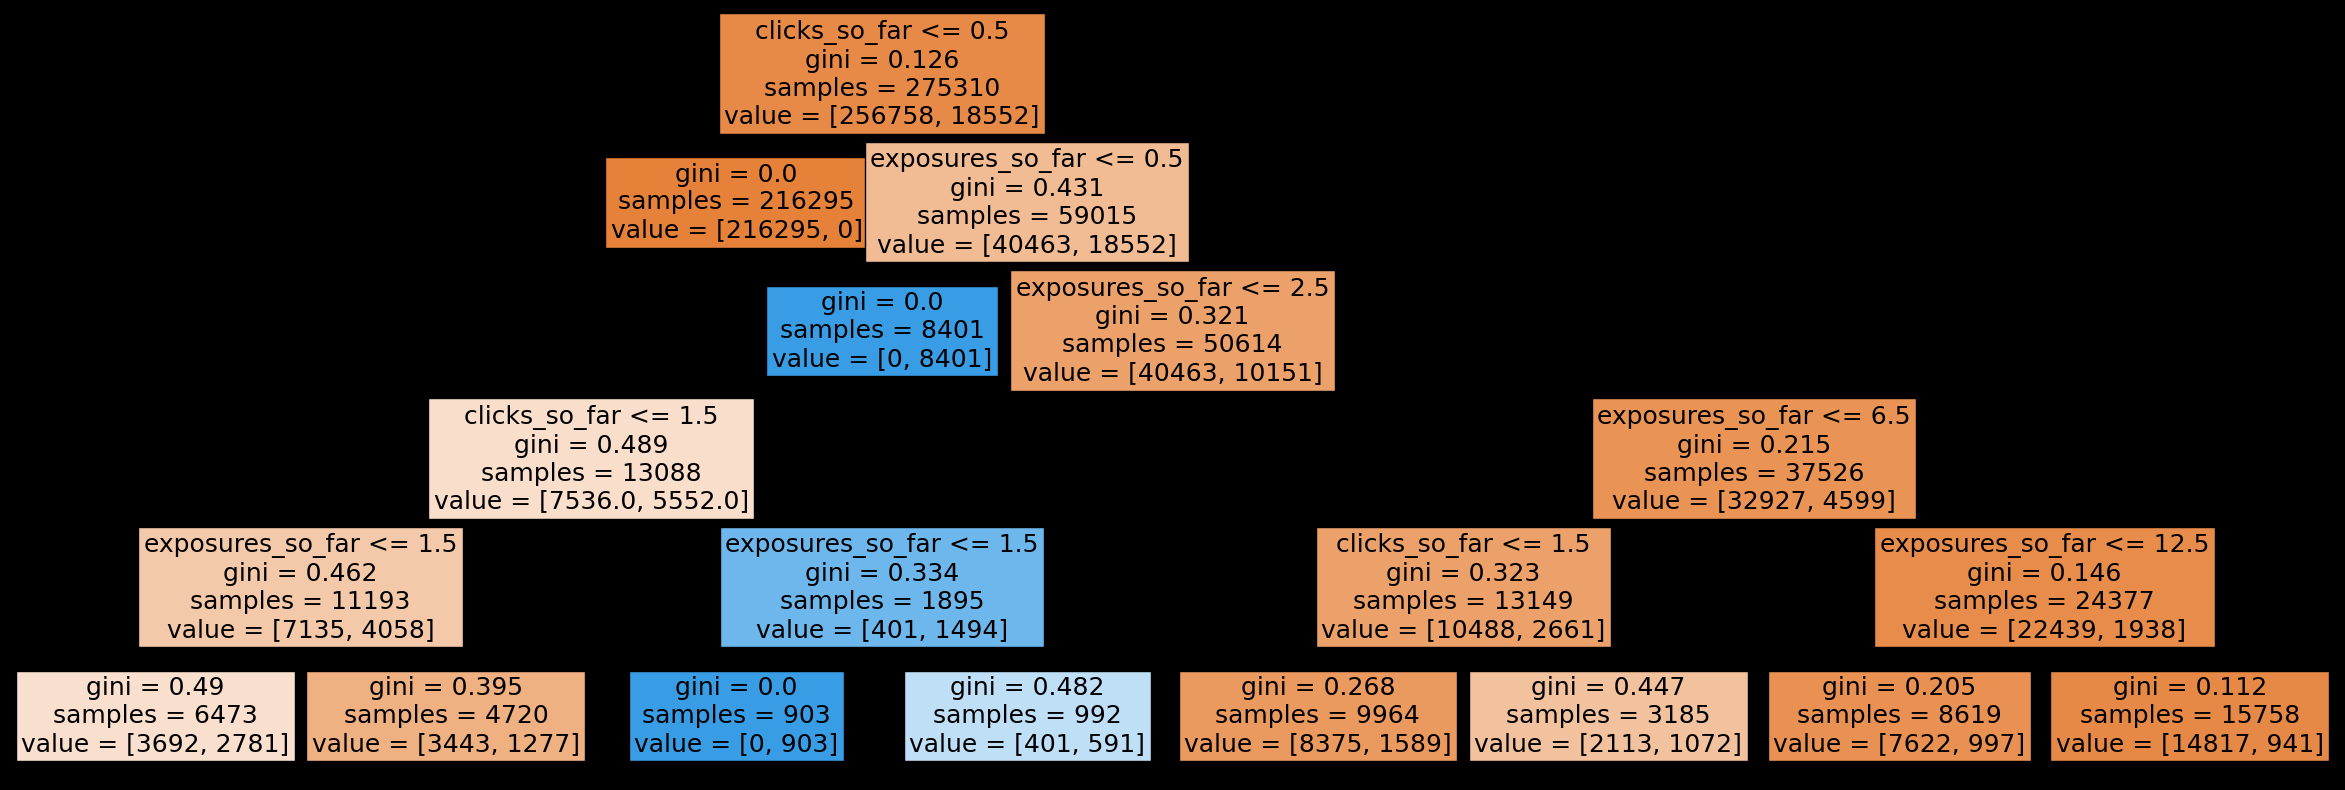

In [51]:
from hepml.core import plot_regression_tree

plot_regression_tree(tree,X_test.columns)

##Ada Boost

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier()

model.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [ ]:
f1_score(model.predict(X_test),y_test)

0.0

In [ ]:
pd.DataFrame(model.predict(X_test)).value_counts()

,count
0,
0.0,91659


## logistic


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train,y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## PCA